https://www.kaggle.com/c/flavours-of-physics/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

raw_data = pd.read_csv('training.csv.zip', index_col='id', compression='zip')
special_cols = ['production', 'mass', 'min_ANNmuon', 'SPDhits', 'IPSig', 'IP_p0p2', 'IP_p1p2']
raw_data.head()

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,...,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,production,signal,mass,min_ANNmuon
id,,,,,,,,,,,,,,,,,,,,,
18453471,0.001578,0.999999,14.033335,0.681401,0.016039,0.451886,1.900433,1482.037476,0.066667,0.060602,...,12290.760742,39264.398438,3.076006,4.003800,4.031514,458,-99,0,1866.300049,0.277559
5364094,0.000988,0.999705,5.536157,0.302341,0.142163,9.564503,0.865666,3050.720703,0.024022,0.019245,...,16562.667969,7341.257812,3.228553,2.786543,2.975564,406,-99,0,1727.095947,0.225924
11130990,0.000877,0.999984,6.117302,0.276463,0.034746,1.970751,10.975849,3895.908691,0.055044,0.047947,...,22695.388672,10225.309570,3.536903,2.865686,3.052810,196,-99,0,1898.588013,0.368630
15173787,0.000854,0.999903,5.228067,0.220739,0.076389,4.271331,3.276358,4010.781738,0.053779,0.006417,...,16909.515625,9141.426758,3.087461,3.218034,2.375592,137,-99,0,1840.410034,0.246045
1102544,0.001129,0.999995,39.069534,1.898197,0.120936,4.984982,0.468348,4144.546875,0.004491,0.037326,...,97612.804688,47118.785156,4.632295,4.711155,4.296878,477,-99,0,1899.793945,0.222060


First, let's do some exploratory data analysis to check how the features are associated with the response signal.

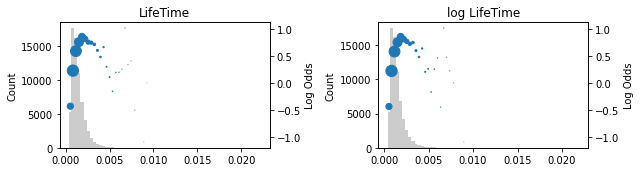

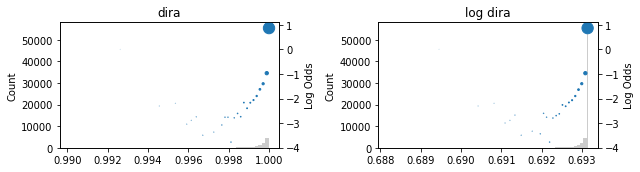

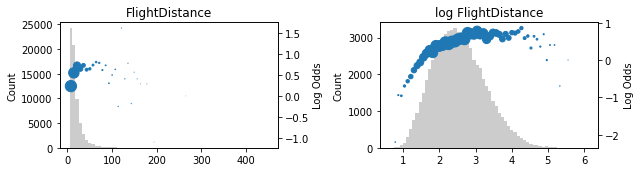

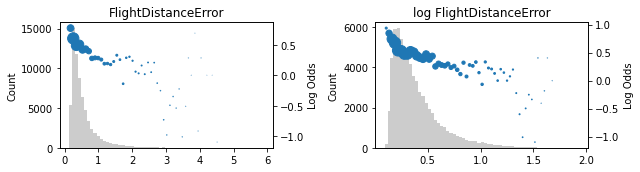

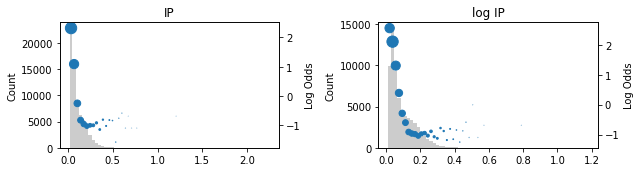

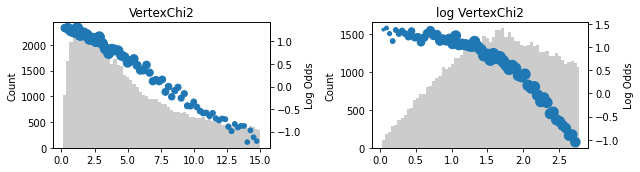

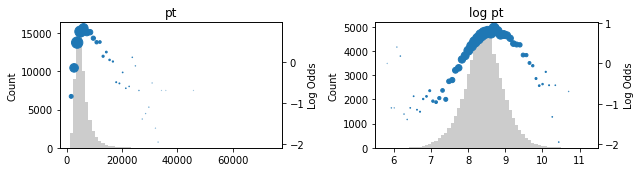

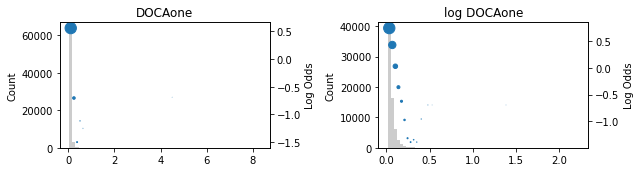

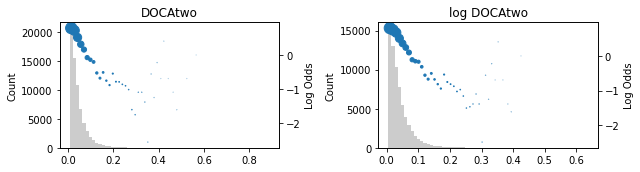

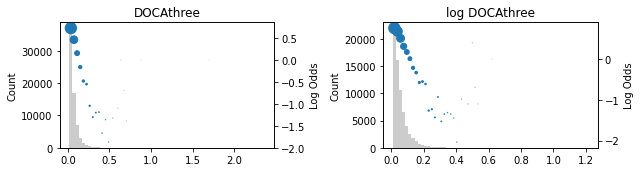

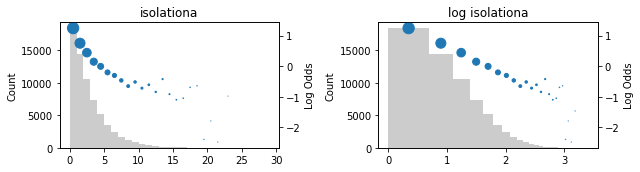

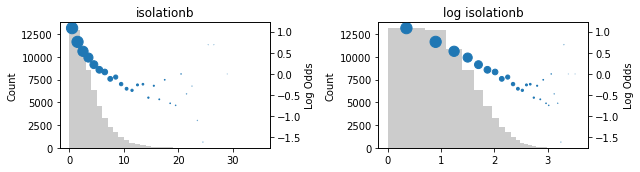

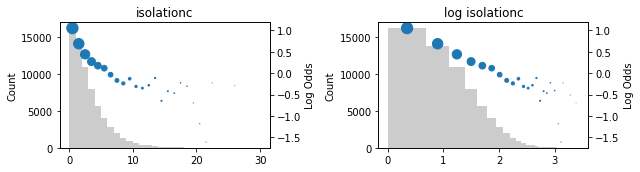

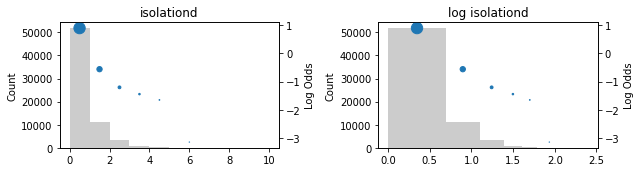

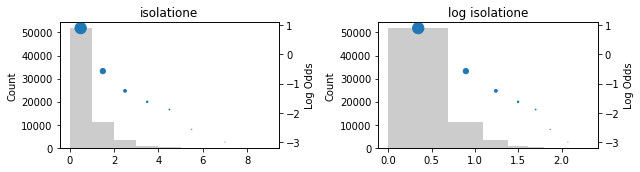

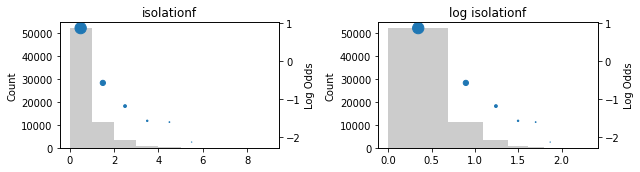

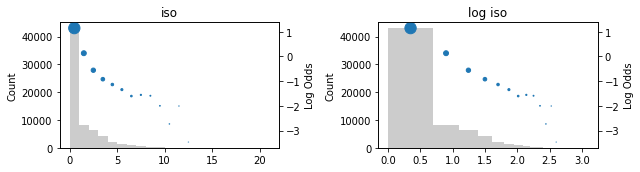

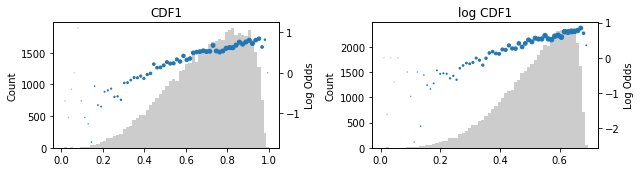

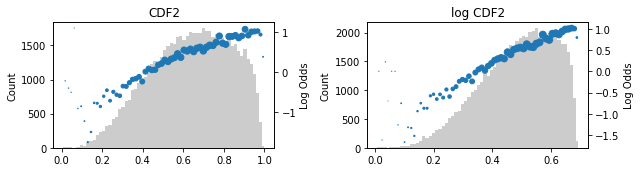

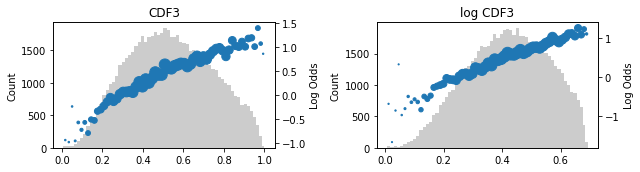

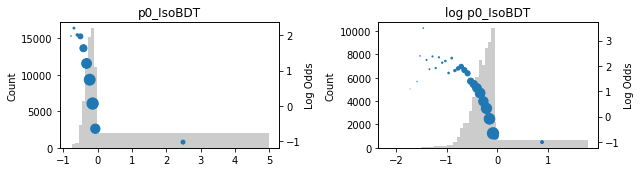

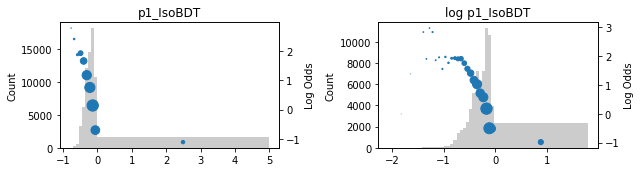

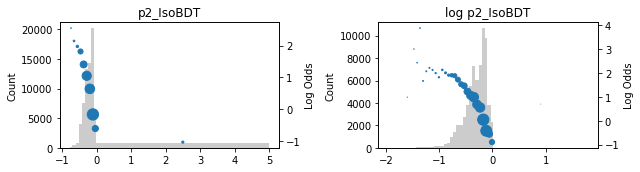

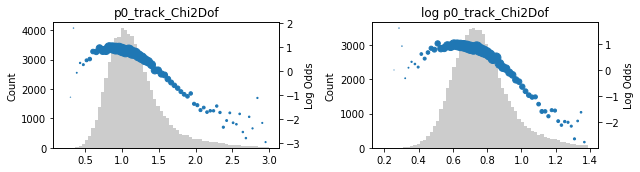

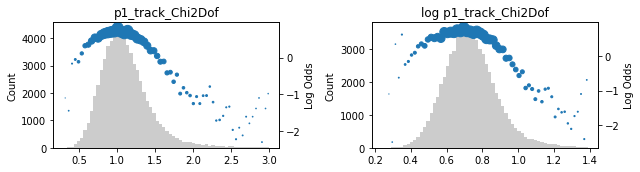

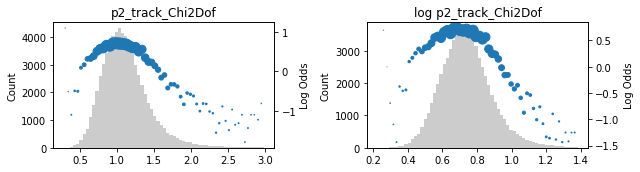

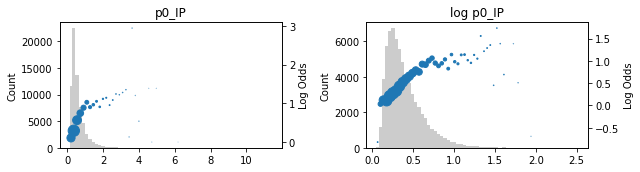

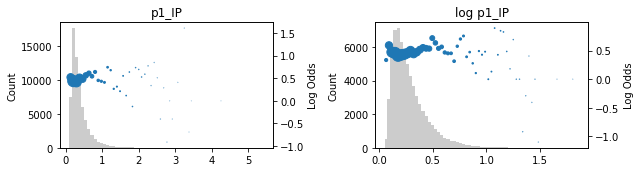

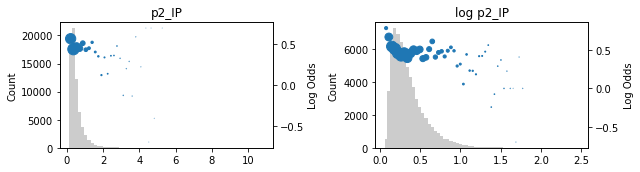

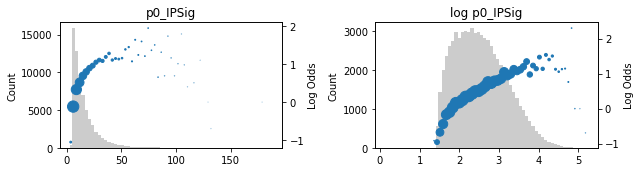

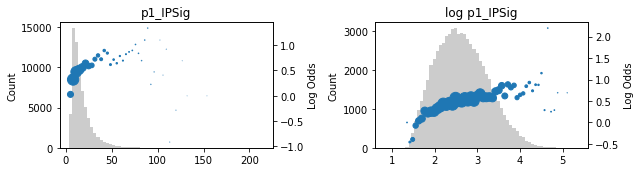

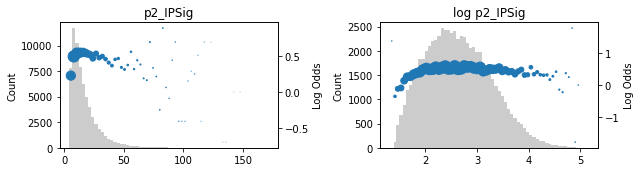

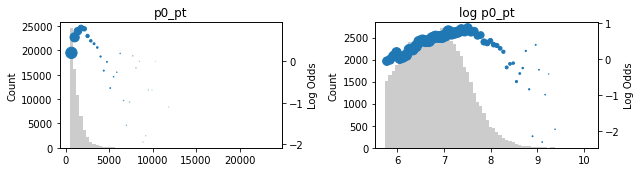

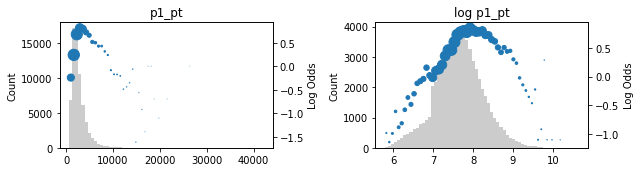

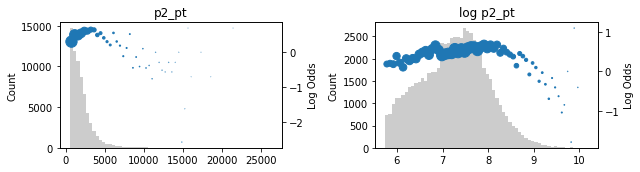

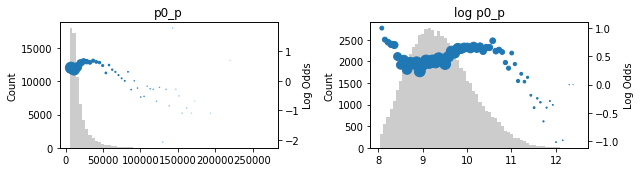

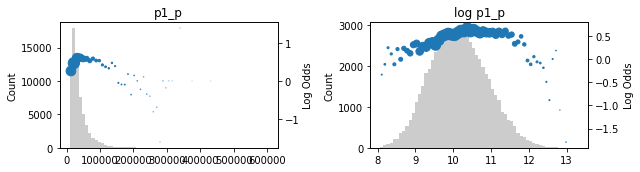

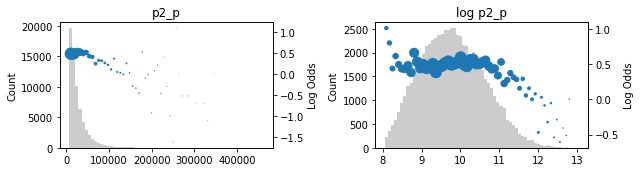

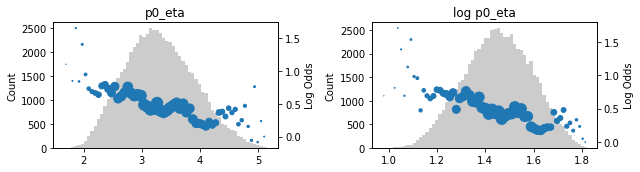

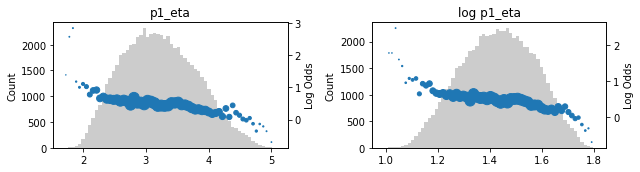

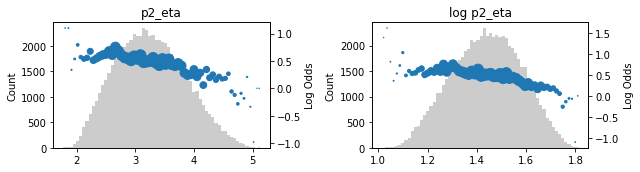

In [2]:
def log_odds(x, y, num_bins):
    """Computes the log odds for a feature x and a binary response y.
    
    The domain of x is discretized into num_bins bins which are not necessarily evenly spaced.
    """
    bins = np.linspace(x.min(), x.max(), num_bins)
    group = (np.digitize(x, bins))
    frame = pd.DataFrame(data={'feature': x.values, 'y': y.values, 'group': group})
    frame = frame.groupby('group')
    p = frame.y.mean()
    mask = (p > 0.0)
    p = p[mask].copy()
    features = frame.feature.mean()[mask]
    support = frame.feature.count()[mask]
    log_odds = np.log(p / (1.0 - p))

    return [features.values, log_odds.values, support.values, frame.feature.mean().values, frame.feature.count().values]

def plot_log_odds(x, y, num_bins, scaling=100.0):
    """Displays a pair of of log odds plots based on feature x and log(1+x)."""

    fig = plt.figure(figsize=(9,2.5))
    ax = fig.add_subplot(1, 2, 1, title=x.name)
    features, lodds, support, full_feat, full_supp = log_odds(x, y, num_bins)
    if len(full_feat) < 3:
        return
    
    plt.ylabel('Count')
    ax.bar(full_feat[:-1], full_supp[:-1], np.diff(full_feat), align='edge', color='k', alpha=0.2)
    ax2 = ax.twinx()
    plt.ylabel('Log Odds')
    ax2.scatter(features[:-1] + 0.5*np.diff(features), lodds[:-1], marker='o', s=scaling*(support[:-1]/np.max(support)))

    features, lodds, support, full_feat, full_supp = log_odds(np.log(1.0 + x), y, num_bins)

    ax = fig.add_subplot(1, 2, 2, title="log "+x.name)
    ax.bar(full_feat[:-1], full_supp[:-1], np.diff(full_feat), align='edge', color='k', alpha=0.2)
    plt.ylabel('Count')
    ax2 = ax.twinx()
    ax2.scatter(features[:-1] + 0.5*np.diff(features), lodds[:-1], marker='o', s=scaling*(support[:-1]/np.max(support)))
    plt.ylabel('Log Odds')
    plt.tight_layout()
    plt.show()

for c in raw_data.columns:
    if c not in special_cols + ['signal', 'ISO_SumBDT']:
        plot_log_odds(raw_data[c], raw_data.signal, 64, 128.0)

This looks like there are some strong associations but no silver bullet. We can also see some nonlinear relationships. Thus, we need a classifier which can produce nonlinear decision boundaries and we opt for a gradient boosting approach. 

In [3]:
data_subset = raw_data.sample(frac=1)
num_train = int(len(raw_data)*8/10)
num_test = int(len(raw_data)*0/10)
num_val = int(len(raw_data)*2/10)

data_train = data_subset.iloc[:num_train,:].copy()
data_test = data_subset.iloc[num_train:num_train+num_test,:].copy()
data_val = data_subset.iloc[num_train+num_test:,:].copy()
print(data_subset.shape, data_train.shape, data_test.shape, data_val.shape )

(67553, 50) (54042, 50) (0, 50) (13511, 50)


In [4]:
def select_predictors_and_response(data, response_col, excluded_cols):
    pred_cols = [e for e in data.columns if e not in [response_col]]
    pred_cols = [e for e in pred_cols if e not in excluded_cols]
    return data[pred_cols].copy(), data[response_col] if response_col else None

X, y = select_predictors_and_response(data_train, 'signal', special_cols)
print(len(X.columns))

42


In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, \
                            PrecisionRecallDisplay, roc_curve, RocCurveDisplay

params = {'n_estimators': 128, 'max_depth': 3, 'subsample': 0.8,
          'learning_rate': 0.05, 'min_samples_leaf': 1, 'random_state': 3,
          'warm_start': True, 'verbose': True
         }
clf = GradientBoostingClassifier(**params)

clf.fit(X, y)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           1.2902           0.0392            1.38m
         2           1.2558           0.0354            1.41m
         3           1.2230           0.0320            1.38m
         4           1.1911           0.0301            1.42m
         5           1.1670           0.0266            1.40m
         6           1.1420           0.0244            1.38m
         7           1.1163           0.0222            1.37m
         8           1.0957           0.0211            1.35m
         9           1.0755           0.0197            1.33m
        10           1.0557           0.0178            1.32m
        20           0.9253           0.0098            1.23m
        30           0.8477           0.0055            1.13m
        40           0.8012           0.0036            1.03m
        50           0.7680           0.0022           55.05s
        60           0.7488           0.0021           47.84s
       

GradientBoostingClassifier(learning_rate=0.05, n_estimators=128, random_state=3,
                           subsample=0.8, verbose=True, warm_start=True)

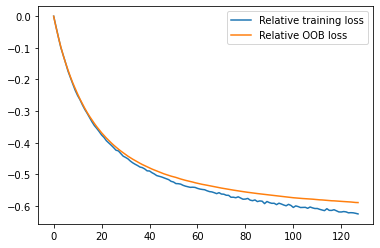

In [6]:
plt.plot(clf.train_score_ - clf.train_score_[0], label='Relative training loss')
plt.plot(-np.cumsum(clf.oob_improvement_) + clf.oob_improvement_[0], label='Relative OOB loss')
plt.legend()
plt.show()

In [7]:
acc = clf.score(X, y)
print(f'accuracy {acc:.3f}')

accuracy 0.861


In [8]:
predictions = clf.predict_proba(X)
X_val, y_val = select_predictors_and_response(data_val, 'signal', special_cols)
predictions_val = clf.predict_proba(X_val)


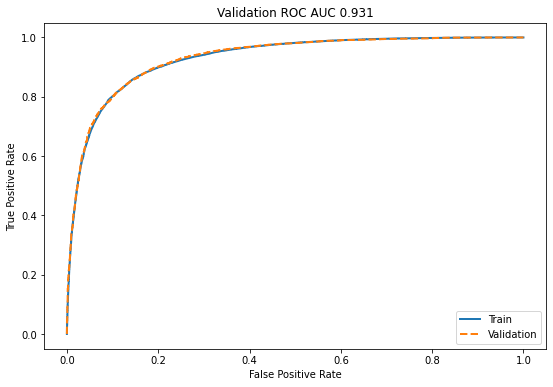

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.title(f'Validation ROC AUC {roc_auc_score(y_val, predictions_val[:,1], average="macro", sample_weight=None):.3f}')

fpr, tpr, _ = roc_curve(y, predictions[:,1], pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, label='Train', linewidth=2, linestyle='-')

fpr, tpr, _ = roc_curve(y_val, predictions_val[:,1], pos_label=1)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=ax, label='Validation', linewidth=2,linestyle='--')

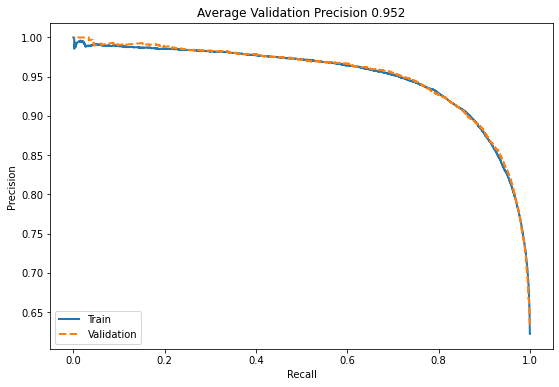

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
plt.title(f'Average Validation Precision {average_precision_score(y_val, predictions_val[:,1], average="macro", sample_weight=None):.3f}')

prec, recall, _ = precision_recall_curve(y, predictions[:,1], pos_label=1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax, label='Train', linewidth=2, linestyle='-')

prec, recall, _ = precision_recall_curve(y_val, predictions_val[:,1], pos_label=1)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot(ax=ax, label='Validation', linewidth=2,  linestyle='--')

In [11]:
pd.DataFrame(pd.Series(predictions[:,1], index=data_train.index, name='prediction')).to_csv('pred.csv')